In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf


### Data Preparation and Feature Engineering 

In [3]:
file_names = []
for file in os.listdir():
    file_names.append(file)
    

In [4]:
len(file_names)

228

In [20]:
df = merge_files()

In [21]:
df.shape

(1415048, 23)

In [459]:
df.dropna(inplace = True)

In [9]:
df.shape

(1329135, 14)

In [462]:
len(columns)

14

In [463]:
for column in columns[2:14]:
    df.drop(df.loc[df[column]=='n.a.'].index, inplace=True)

In [464]:
df.dtypes

Country                                       object
Operating revenue (Turnover)\nth EUR 2017     object
Operating revenue (Turnover)\nth EUR 2018     object
Operating revenue (Turnover)\nth EUR 2019     object
Operating revenue (Turnover)\nth EUR 2020     object
Operating P/L [=EBIT]\nth EUR 2017            object
Operating P/L [=EBIT]\nth EUR 2018            object
Operating P/L [=EBIT]\nth EUR 2019            object
Operating P/L [=EBIT]\nth EUR 2020            object
Number of employees\n2020                     object
Number of employees\n2019                     object
Number of employees\n2018                     object
Number of employees\n2017                     object
NACE Rev. 2, core code (4 digits)            float64
dtype: object

In [465]:
df[columns[2:13]] = df[columns[2:13]].astype(str).astype(float)

In [467]:
df[columns[13]] = df[columns[13]].astype(str).astype(object)

### Data preperation and Model building/Training/Predicting

In [309]:
model_data = df[columns[1:13]]

In [310]:
#model_data = pd.get_dummies(model_data, columns=["Country"])

In [365]:
train_data,test_data = train_test_split(model_data,test_size = .5,random_state =43)
X_train,X_validation = train_test_split(train_data,test_size = .3,random_state =43)train_data,test_data = train_test_split(model_data,test_size = .5,random_state =43)
X_train,X_validation = train_test_split(train_data,test_size = .3,random_state =43)

In [380]:
pipeline = Pipeline([("normalizer",Normalizer()),('scaler', MinMaxScaler())])

In [381]:
X_train_transformed = pipeline.fit_transform(X_train)
X_validate_transformed = pipeline.transform(X_validation)

In [382]:
#model

# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 512
EPOCHS = 30

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(32, activation='elu')
 ,
    
    # reconstruction / decode

    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 12)                156       
                                                                 
 dense_44 (Dense)            (None, 32)                416       
                                                                 
 dense_45 (Dense)            (None, 32)                1056      
                                                                 
 dense_46 (Dense)            (None, 12)                396       
                                                                 
Total params: 2,024
Trainable params: 2,024
Non-trainable params: 0
_________________________________________________________________


In [383]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)



# callbacks argument only takes a list
cb = [save_model]


In [384]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/30
909/909 [==============================] - 2s 2ms/step - loss: 0.0080 - acc: 0.6882 - val_loss: 9.7958e-04 - val_acc: 0.8295
Epoch 2/30
909/909 [==============================] - 1s 1ms/step - loss: 5.9672e-04 - acc: 0.8912 - val_loss: 3.1166e-04 - val_acc: 0.9343
Epoch 3/30
909/909 [==============================] - 1s 1ms/step - loss: 1.6752e-04 - acc: 0.9431 - val_loss: 6.7562e-05 - val_acc: 0.9451
Epoch 4/30
909/909 [==============================] - 1s 1ms/step - loss: 3.3622e-05 - acc: 0.9497 - val_loss: 1.5099e-05 - val_acc: 0.9530
Epoch 5/30
909/909 [==============================] - 1s 1ms/step - loss: 1.2464e-05 - acc: 0.9536 - val_loss: 1.0453e-05 - val_acc: 0.9545
Epoch 6/30
909/909 [==============================] - 1s 1ms/step - loss: 9.9137e-06 - acc: 0.9549 - val_loss: 8.1590e-06 - val_acc: 0.9562
Epoch 7/30
909/909 [==============================] - 1s 1ms/step - loss: 8.3669e-06 - acc: 0.9557 - val_loss: 9.4579e-06 - val_acc: 0.9470
Epoch 8/30
909/909 [====

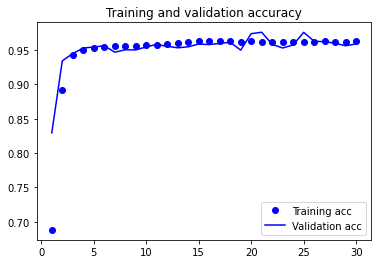

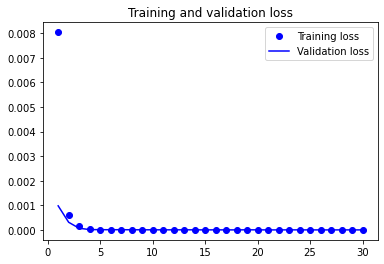

In [385]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [387]:
# pass the transformed test set through the autoencoder to get the reconstructed result
test_data_scaled = pipeline.transform(test_data)
reconstructions = autoencoder.predict(test_data_scaled)

## Results 

In [205]:
import numpy as np 

In [388]:
mse = np.mean(np.power(test_data_scaled - reconstructions, 2), axis=1)

(array([1., 0., 0., 0.]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

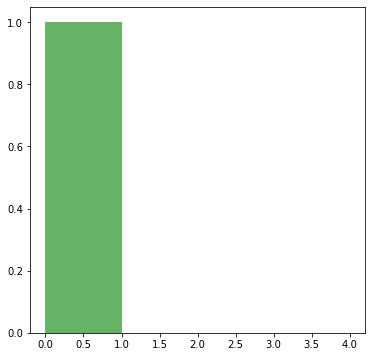

In [389]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(mse*1000, range(0,5), density=True, alpha=.6, color="green")

In [390]:
rec_df = pd.DataFrame(reconstructions)
org_df = pd.DataFrame(test_data_scaled)

In [393]:
compare = pd.DataFrame({"predict":rec_df[3],"original":org_df[3],"x":org_df[4]})

In [394]:
compare

,predict,original,x
0,0.508511,0.507827,0.559645
1,0.617620,0.617900,0.551338
2,0.612636,0.612958,0.500000
3,0.551244,0.551507,0.446961
4,0.510205,0.510066,0.457662
...,...,...,...
664477,0.691563,0.691727,0.578239
664478,0.711687,0.711636,0.506106
664479,0.789618,0.789440,0.502301
664480,0.405120,0.404382,0.515190


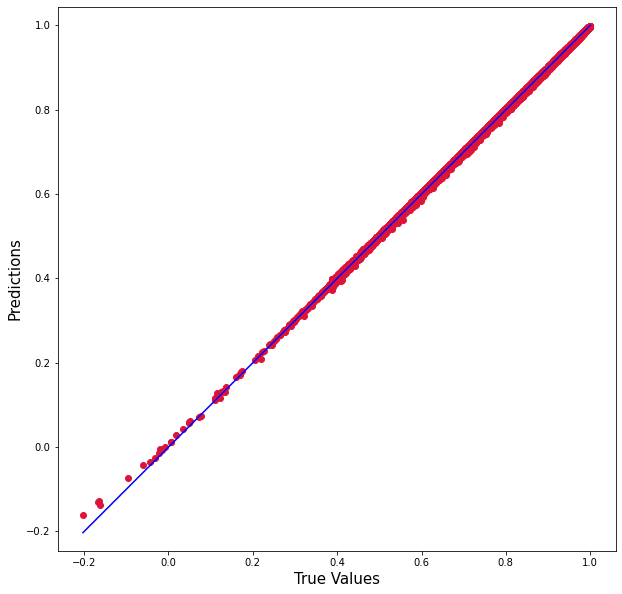

In [395]:
plt.figure(figsize=(10,10))
plt.scatter(compare.original,compare.predict, c='crimson')

p1 = max(max(compare.predict), max(compare.original))
p2 = min(min(compare.predict), min(compare.original))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

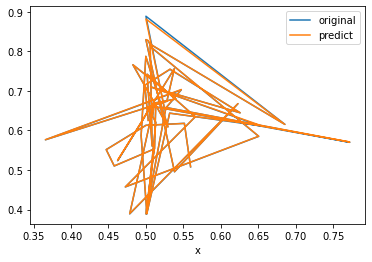

In [396]:
compare[:50].plot(x="x", y=["original", "predict"])
plt.show()

In [397]:

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)

(array([6.69326512e-01, 1.60738394e-01, 4.11752447e-02, 2.37226553e-02,
        1.60753495e-02, 2.24752867e-02, 9.02152541e-03, 7.40719487e-03,
        6.14925535e-03, 5.45459488e-03, 4.22987825e-03, 3.78891986e-03,
        3.10936070e-03, 2.80733441e-03, 2.66236179e-03, 2.01451538e-03,
        1.78044501e-03, 1.47539845e-03, 1.30777385e-03, 1.16129110e-03,
        1.42405398e-03, 9.74034799e-04, 7.98859549e-04, 9.77055062e-04,
        7.44494816e-04, 6.59927453e-04, 7.36944158e-04, 6.22174166e-04,
        5.05894043e-04, 5.33076410e-04, 3.92634183e-04, 4.37938127e-04,
        3.53370764e-04, 3.50350502e-04, 3.48840370e-04, 3.11087083e-04,
        3.05046557e-04, 2.71823665e-04, 2.40110904e-04, 2.28029852e-04,
        2.43131167e-04, 2.55212219e-04, 2.28029852e-04, 2.82394585e-04,
        1.96317091e-04, 5.60258776e-04, 1.99337354e-04, 1.66114462e-04,
        1.38932095e-04, 1.37421964e-04, 1.44972621e-04, 1.34401701e-04,
        1.01178809e-04, 1.13259860e-04]),
 array([ 0,  1,  2,  3

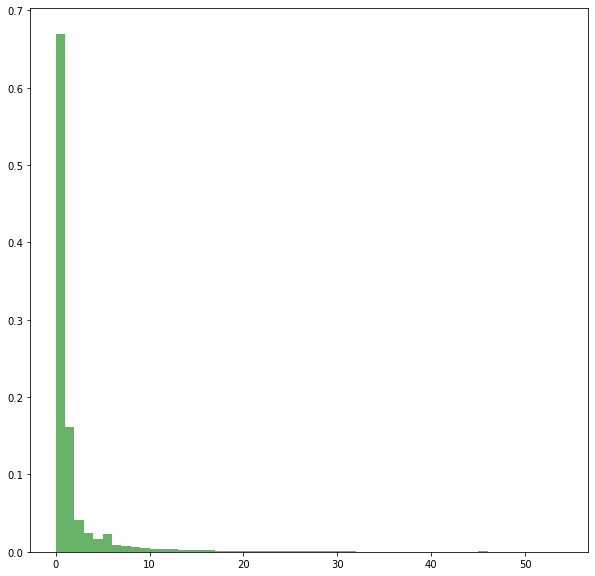

In [398]:
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(z_scores,range(0,55),density=True, alpha=.6, color="green")

In [399]:
print(min(z_scores))
print(max(z_scores))
print(np.mean(z_scores))
print(np.quantile(z_scores, .99))

1.2704462049299772e-06
1541.918803455344
2.263442577846537
29.175187503189115


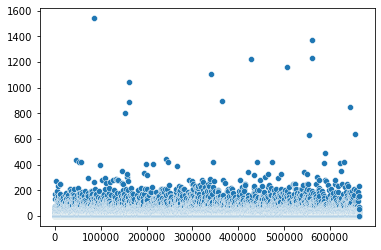

In [400]:
import seaborn as sns 
array = list(range(len(z_scores)))
sns.scatterplot(x = array,y = z_scores)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ticklabel_format(style='plain', axis='x',useOffset=False)

In [401]:
outliers = z_scores > 200
clean = mse[outliers==False]
fraud = mse[outliers==True]

len(fraud)/len(mse)*100

0.02633630406843225

In [402]:
label = []


for i in outliers:
    if i == True:
        label.append(1)
    else:
        label.append(0)

In [403]:
org_df["Label"] = label

In [404]:
rec_df["z-score"] = z_scores

In [406]:
rec_df["Label"] = label

<AxesSubplot:xlabel='1', ylabel='1'>

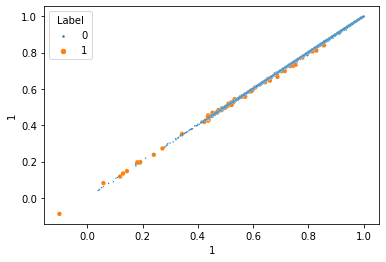

In [407]:
sns.scatterplot(x = org_df[1],y = rec_df[1],hue =rec_df["Label"],size=rec_df["Label"],sizes=(20, 2))

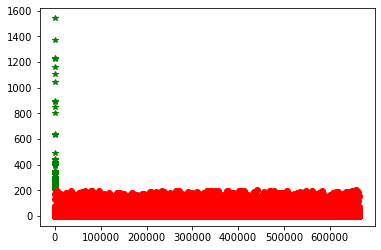

In [408]:
outlier = list(rec_df.loc[rec_df["Label"]==1]["z-score"])
normal = list(rec_df.loc[rec_df["Label"]==0]["z-score"])
plt.plot(outlier,'g*', normal, 'ro')
plt.show()

In [409]:
array = list(range(len(rec_df["z-score"])))

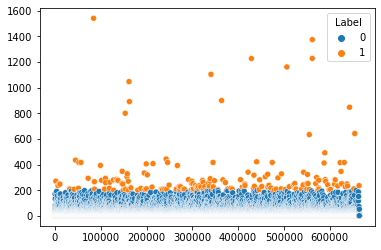

In [410]:
sns.scatterplot(x = array,y = z_scores,hue = rec_df["Label"])
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ticklabel_format(style='plain', axis='x',useOffset=False)

In [412]:
pca_data = rec_df[org_df.columns[:12]]

In [413]:
scaler = StandardScaler() 
pca_data = scaler.fit_transform(pca_data)

In [414]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(pca_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, org_df[org_df.columns[12]]], axis = 1)
finalDf.head()

,principal component 1,principal component 2,Label
0,-0.137728,1.814691,0
1,-0.034753,-0.354952,0
2,1.447167,-1.000076,0
3,0.827660,0.373653,0
4,-0.863493,0.126416,0


In [415]:
finalDf["Label"].value_counts()

0    664307
1       175
Name: Label, dtype: int64

In [416]:
org_df.shape

(664482, 13)

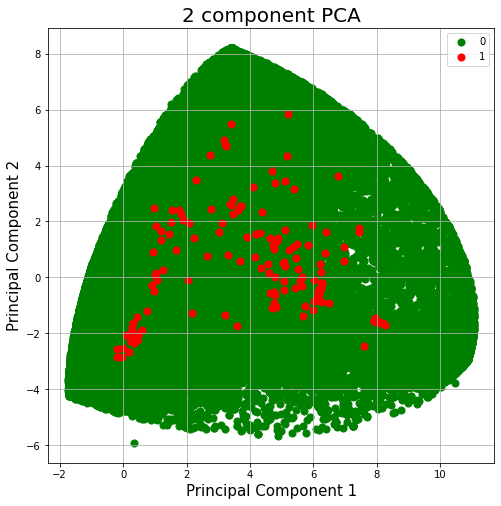

In [417]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

##  Autoencoder method with Pyod library 

In [263]:
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

In [418]:
X_train_pyod,X_test_pyod = train_test_split(model_data,test_size = .50,random_state =43)

In [436]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_pyod)    # Only the training data are used to fit the scaler transformation,
X_train_scaled = scaler.transform(X_train_pyod) 
X_test_scaled = scaler.transform(X_test_pyod)  # then the scaler is used to transform the test input data.
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [437]:
X_test_scaled.shape

(664482, 12)

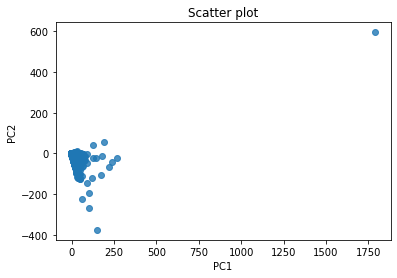

In [438]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train_scaled)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
x_pca.head()

# Plot
import matplotlib.pyplot as plt
plt.scatter(x_pca["PC1"], x_pca["PC2"], alpha=0.8) 
plt.title('Scatter plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [439]:
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25],epochs=30,batch_size=512, validation_size=0.3,
                   preprocessing=False,random_state=43)
clf1.fit(X_train_scaled)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 12)                156       
                                                                 
 dropout_18 (Dropout)        (None, 12)                0         
                                                                 
 dense_55 (Dense)            (None, 12)                156       
                                                                 
 dropout_19 (Dropout)        (None, 12)                0         
                                                                 
 dense_56 (Dense)            (None, 25)                325       
                                                                 
 dropout_20 (Dropout)        (None, 25)                0         
                                                                 
 dense_57 (Dense)            (None, 2)               

AutoEncoder(batch_size=512, contamination=0.1, dropout_rate=0.2, epochs=30,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fe66a04eee0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=False,
      random_state=43, validation_size=0.3, verbose=1)

In [440]:
y_train_scores = clf1.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf1.predict(X_test_scaled)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf1.decision_function(X_test_scaled)  # outlier scores

y_test_pred = pd.Series(y_test_pred)
y_test_scores = pd.Series(y_test_scores)

In [ ]:

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

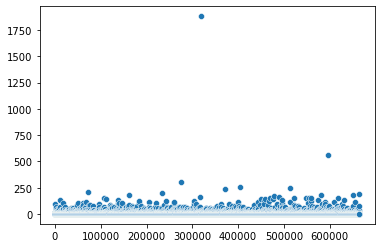

In [441]:
array = list(range(len(y_test_scores)))
sns.scatterplot(x = array,y = y_test_scores)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ticklabel_format(style='plain', axis='x',useOffset=False)

In [363]:
df_test.shape

(664482, 14)

In [442]:
df_test = X_test_scaled.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<125, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,score
cluster,,,,,,,,,,,,,
0,-0.003084,-0.002609,-0.002692,-0.003390,-0.001341,-0.001523,-0.001474,-0.001730,-0.002403,-0.002611,-0.003031,-0.002292,0.713691
1,38.556635,45.845095,43.759932,36.790207,1.179969,6.021382,1.372805,1.297815,56.880489,48.051975,47.912129,101.259591,235.527235


<AxesSubplot:xlabel='cluster'>

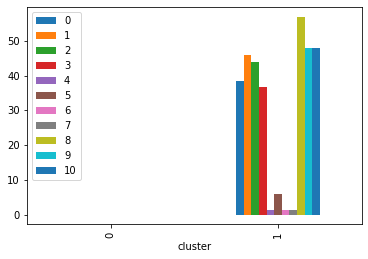

In [443]:
sample = df_test.groupby('cluster').mean()
sample = sample.reset_index(level=0)
sample[sample.columns[:12]].plot(x='cluster', kind="bar")

In [537]:
pca = PCA(n_components=2)
scaler = StandardScaler() 
df_test_scaled = scaler.fit_transform(df_test[df_test.columns[0:12]]) 
principalComponents = pca.fit_transform(df_test_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_test[df_test.columns[12:14]]],axis = 1)
finalDf.head()

,principal component 1,principal component 2,score,cluster
0,-0.533137,-0.119791,0.508206,0
1,-0.529051,-0.124865,0.512062,0
2,-0.489806,-0.062140,0.432206,0
3,-0.486863,-0.052520,0.430582,0
4,1.158572,-0.163519,1.696781,0


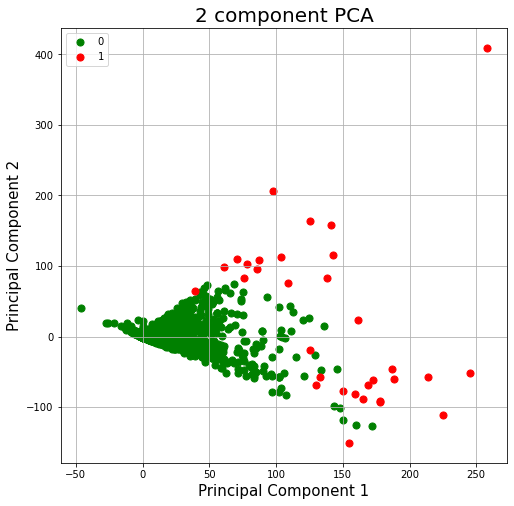

In [445]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Anomalies based on NACE code

In [470]:
df.rename(columns = {"NACE Rev. 2, core code (4 digits)":'NACE'},inplace = True)

In [473]:
df["NACE"].value_counts()

4640.0    17640
4720.0    15576
5510.0    15237
8622.0    13888
6810.0    13547
          ...  
5122.0        1
4778.0        1
6820.0        1
4321.0        1
8400.0        1
Name: NACE, Length: 741, dtype: int64

In [475]:
len(df["NACE"].value_counts())

741

In [478]:
a = dict(df["NACE"].value_counts())

In [486]:
new_map = {}
for i in a.keys():
    if a[i]>10000:
        new_map[i]=i
    else:
        new_map[i]=1

In [490]:
df.replace({"NACE": new_map},inplace = True)

In [495]:
model_data = df[df.columns[1:14]]

In [503]:
X_train_pyod_new,X_test_pyod_new = train_test_split(model_data,test_size = .50,random_state =43)

In [538]:
finalDf["NACE"]= list(X_test_pyod_new["NACE"])

In [539]:
finalDf

,principal component 1,principal component 2,score,cluster,NACE
0,-0.533137,-0.119791,0.508206,0,1
1,-0.529051,-0.124865,0.512062,0,1
2,-0.489806,-0.062140,0.432206,0,1
3,-0.486863,-0.052520,0.430582,0,1
4,1.158572,-0.163519,1.696781,0,1
...,...,...,...,...,...
664477,-0.449495,-0.026298,0.384031,0,1
664478,0.137363,0.113417,0.206713,0,1
664479,-0.148837,0.193483,0.231608,0,1
664480,-0.478713,-0.040223,0.418770,0,1


In [556]:
nace_df = finalDf[["cluster","NACE"]]

In [560]:
codes = list(nace_df["NACE"].unique())

In [570]:
percentages = {}
for i in codes:
    n = dict(nace_df["NACE"].value_counts())[i]
    p = n/len(nace_df["NACE"])*100
    d = nace_df.loc[nace_df["NACE"]==i]
    try:
        c = dict(d["cluster"].value_counts())[1]
        cluster_p = (c/d.shape[0])*100
    except:
        cluster_p = 0
    
    percentages[i]=[p,cluster_p]

In [575]:
NACE = pd.DataFrame(percentages).transpose()


In [576]:
NACE

,0,1
1,82.002522,0.005506
4642.0,0.826508,0.000000
1812.0,0.775341,0.000000
7490.0,0.925382,0.000000
4720.0,1.174298,0.000000
8299.0,0.993405,0.000000
4759.0,0.913343,0.000000
4646.0,0.768569,0.039162
4932.0,0.973089,0.000000
7911.0,0.921319,0.000000


## Most outlier contained category - 4646.0 - Wholesale of pharmaceutical goods 

In [580]:
outlier_percentage = (finalDf["cluster"].value_counts()[1]/finalDf.shape[0])*100
print(outlier_percentage)

0.004815781315370469


## Overall outlier percentage on test data - 0.004